In [1]:
# import new_model_integration as model_mobster_mv
import model_mobster as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
import scipy.stats as stats
import torch
import pyro
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

/Users/elenarivaroli/miniconda3/envs/mobster/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hitchhikers

In [12]:
NV = pd.read_csv("./data/hitchhikers/NV_bigger.csv")
DP = pd.read_csv("./data/hitchhikers/DP_bigger.csv")
NV = torch.tensor(NV.values)
DP = torch.tensor(DP.values)

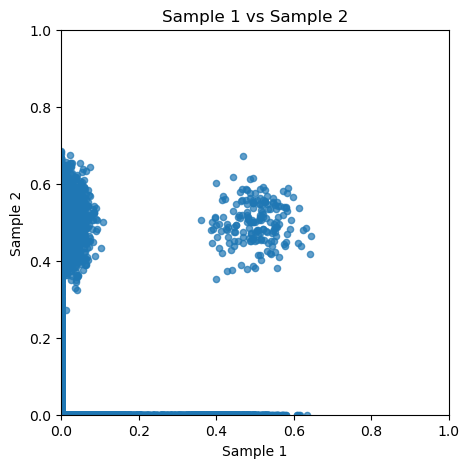

In [13]:
D = NV.shape[1]
pairs = np.triu_indices(D, k=1)  # Generate all unique pairs of samples (i, j)
vaf = NV/DP    


num_pairs = len(pairs[0])  # Number of unique pairs
# ncols = 3
ncols = min(3, num_pairs)
nrows = (num_pairs + ncols - 1) // ncols  # Calculate the number of rows

fig_width_per_plot = 5
fig_width = ncols * fig_width_per_plot
fig_height = 5 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
if num_pairs == 1:
    axes = [axes]
else:
    axes = axes.flatten()

idx = 0
for i, j in zip(*pairs):
    ax = axes[idx]  # Select the appropriate subplot
    x = vaf[:, i].numpy()
    y = vaf[:, j].numpy()

    ax.scatter(x, y, alpha=0.7, s = 20)

    ax.set_title(f"Sample {i+1} vs Sample {j+1}")
    ax.set_xlabel(f"Sample {i+1}")
    ax.set_ylabel(f"Sample {j+1}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    idx += 1

plt.show()

In [14]:
NV.shape

torch.Size([37202, 2])

In [15]:
vaf = NV/DP
cond = vaf[np.where((vaf[:,0] > 0) & (vaf[:,0] < 0.2)& (vaf[:,1] > 0.4))]
cond.shape

torch.Size([1443, 2])

In [16]:
vaf = NV/DP
cond2 = vaf[np.where((vaf[:,0] > 0.3) & (vaf[:,1] > 0.3))]
cond2.shape

torch.Size([188, 2])

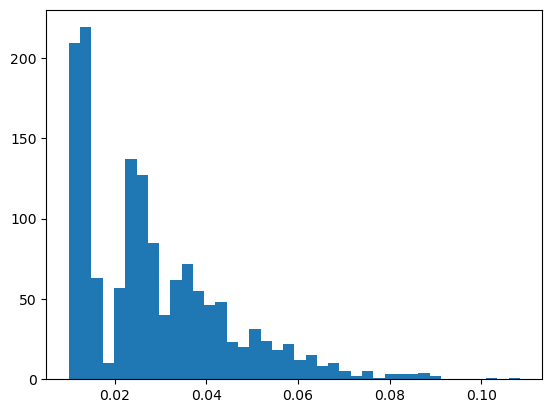

In [17]:
plt.hist(cond[:,0], bins = 40);

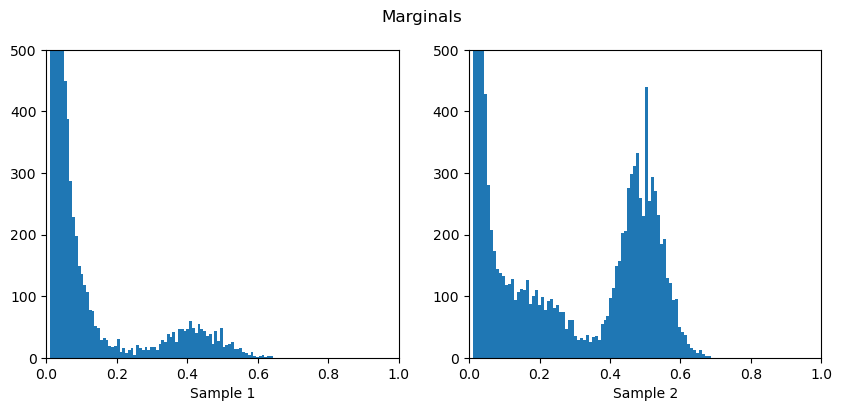

In [18]:
fig, axes = plt.subplots(1, D, figsize=(5*D, 4))
plt.suptitle("Marginals")

for i in range(D):
    x = vaf[:, i].numpy()
    x = x[x > 0]
    axes[i].hist(x, bins = 80)    
    
    axes[i].set_xlabel(f"Sample {i+1}")
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([0,500])
plt.show()

In [19]:
torch.tensor([[0.02, 0.5], # tail asse x, clonal assse y (hitchhiker)
                [1.0e-10, 0.02], # tail asse y
                [0.02, 1.0e-10], # tail asse x
                [1.0000e-10, 2.0172e-01], # subclonal asse y
                [0.5, 1.0000e-10], # clonal asse x private
                [0.5, 0.5], # clonal, clonal
                [1.0000e-10, 0.5]]) # clonal asse y private

tensor([[2.0000e-02, 5.0000e-01],
        [1.0000e-10, 2.0000e-02],
        [2.0000e-02, 1.0000e-10],
        [1.0000e-10, 2.0172e-01],
        [5.0000e-01, 1.0000e-10],
        [5.0000e-01, 5.0000e-01],
        [1.0000e-10, 5.0000e-01]])

No GPU available.
RUN WITH K = 6 AND SEED = 42
Minimum detected VAF: tensor(0.0100)


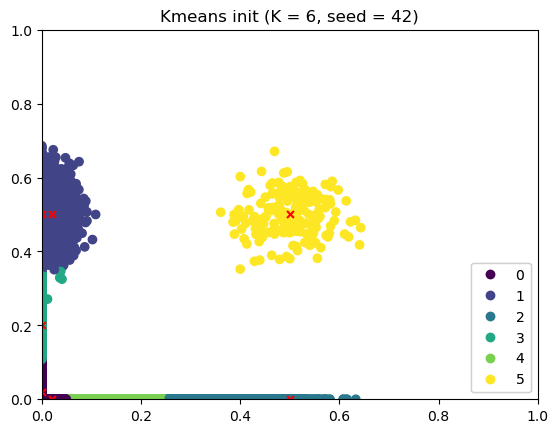

kmeans_centers:  tensor([[2.0000e-02, 5.0000e-01],
        [1.0000e-10, 2.0000e-02],
        [2.0000e-02, 1.0000e-10],
        [1.0000e-10, 2.0172e-01],
        [5.0000e-01, 1.0000e-10],
        [5.0000e-01, 5.0000e-01],
        [1.0000e-10, 5.0000e-01]])
Init delta:  tensor([[[0.6000, 0.3000, 0.1000],
         [0.3000, 0.6000, 0.1000]],

        [[0.1000, 0.3000, 0.6000],
         [0.6000, 0.3000, 0.1000]],

        [[0.6000, 0.3000, 0.1000],
         [0.1000, 0.3000, 0.6000]],

        [[0.1000, 0.3000, 0.6000],
         [0.3000, 0.6000, 0.1000]],

        [[0.3000, 0.6000, 0.1000],
         [0.1000, 0.3000, 0.6000]],

        [[0.3000, 0.6000, 0.1000],
         [0.3000, 0.6000, 0.1000]]])


ValueError: Shape mismatch inside plate('plate_probs') at site phi_beta dim -2, 6 vs 7
     Trace Shapes:        
      Param Sites:        
     weights_param     6  
alpha_pareto_param   6 2  
    phi_beta_param   7 2  
      k_beta_param   6 2  
probs_pareto_param   6 2  
       delta_param 6 2 3  
     Sample Sites:        
      weights dist     | 6
             value     | 6
   plate_dims dist     |  
             value   2 |  
  plate_probs dist     |  
             value   6 |  
 alpha_pareto dist 6 2 |  
             value 6 2 |  

In [21]:
K_list = [6]
seed_list = [42]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01)#, choice_init_centers = 'kmeans')